In [6]:
import os
import json
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
BASE_DIR = "data"


In [8]:
def process_json_files(base_dir="data"):
    submissoes = []

    if not os.path.exists(base_dir):
        print(f"Diretório {base_dir} não encontrado.")
        return pd.DataFrame()

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = json.load(f)

                    submission = content.get("data", {}).get("submissionDetails", {})

                    if not submission or not submission.get("code"):
                        print(f"JSON ignorado: {file_path} - Dados insuficientes ou código ausente.")
                        continue

                    model = root.split(os.sep)[-2]
                    problem_slug = submission.get("question", {}).get("titleSlug", "")
                    language = submission.get("lang", {}).get("name", "")
                    status_code = submission.get("statusCode", None)
                    total_correct = submission.get("totalCorrect", 0)
                    total_tests = submission.get("totalTestcases", 0)
                    runtime = submission.get("runtime", None)
                    memory = submission.get("memory", None)
                    timestamp = submission.get("timestamp", None)
                    code = submission.get("code", "")

                    submissoes.append({
                        "model": model,
                        "problem": problem_slug,
                        "language": language,
                        "status_code": status_code,
                        "total_correct": total_correct,
                        "total_tests": total_tests,
                        "runtime": runtime,
                        "memory": memory,
                        "timestamp": datetime.fromtimestamp(timestamp) if timestamp else None,
                        "code": code,
                        "source_file": file_path
                    })

                except Exception as e:
                    print(f"Erro ao processar {file_path}: {e}")

    return pd.DataFrame(submissoes)


In [9]:
df = process_json_files()
print(f"Total de submissões processadas: {len(df)}")
df.head()


JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\30_substring-with-concatenation-of-all-

,model,problem,language,status_code,total_correct,total_tests,runtime,memory,timestamp,code,source_file
0,121_best-time-to-buy-and-sell-stock,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15220000,2025-06-01 22:20:50,#include <stdio.h>\n#include <stdlib.h>\n\n// ...,data\henrique_problems\easy\121_best-time-to-b...
1,121_best-time-to-buy-and-sell-stock,best-time-to-buy-and-sell-stock,python3,10,212.0,212,80,19284000,2025-06-01 22:23:55,class Solution(object):\n def maxProfit(sel...,data\henrique_problems\easy\121_best-time-to-b...
2,121_best-time-to-buy-and-sell-stock,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15312000,2025-06-01 22:21:22,#include <stdio.h>\n#include <limits.h>\n\nint...,data\henrique_problems\easy\121_best-time-to-b...
3,121_best-time-to-buy-and-sell-stock,best-time-to-buy-and-sell-stock,python3,10,212.0,212,24,18992000,2025-06-01 22:24:39,class Solution(object):\n def maxProfit(sel...,data\henrique_problems\easy\121_best-time-to-b...
4,121_best-time-to-buy-and-sell-stock,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15372000,2025-06-01 22:19:44,#include <stdio.h>\n\nint maxProfit(int* price...,data\henrique_problems\easy\121_best-time-to-b...


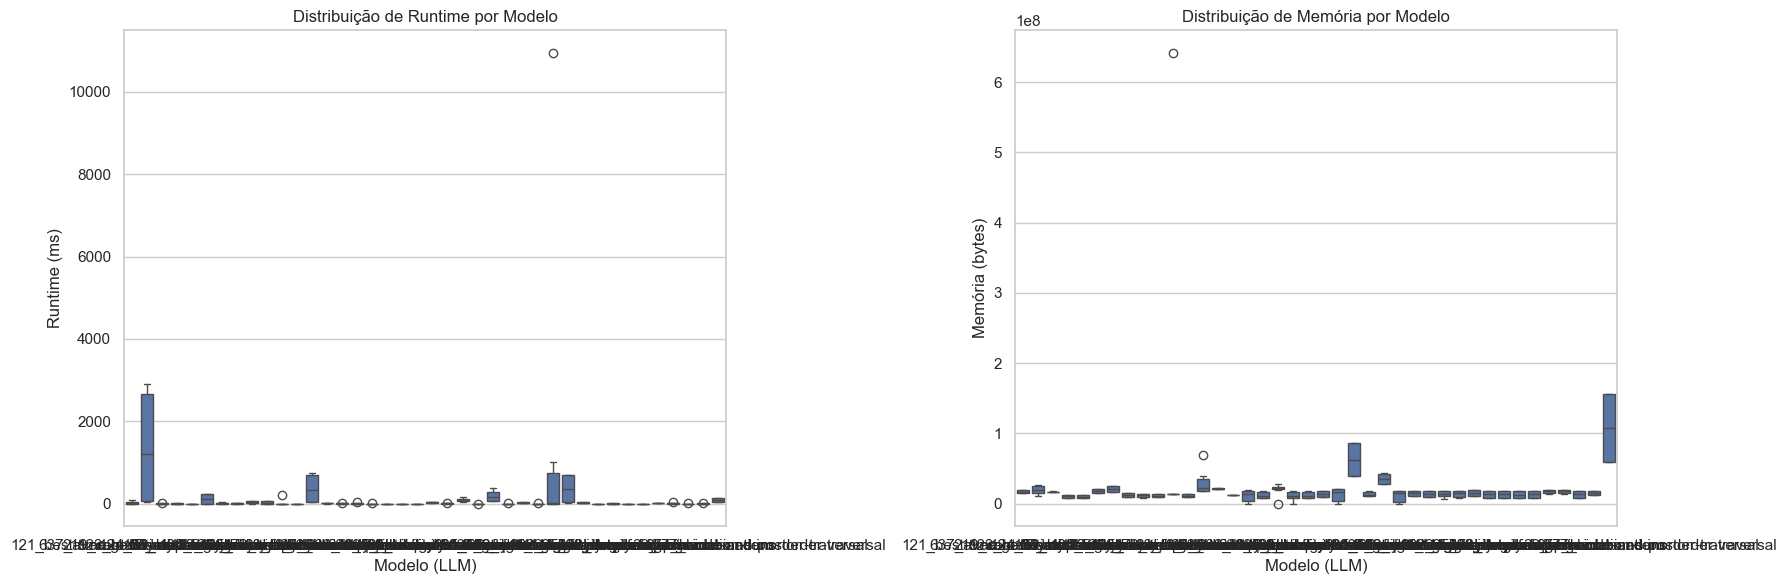

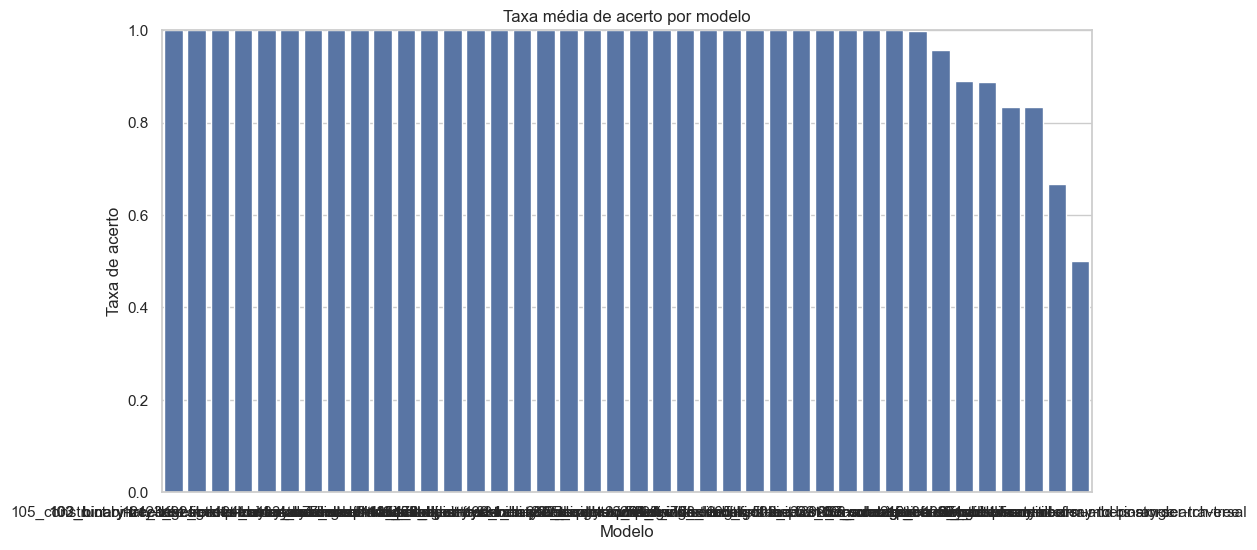

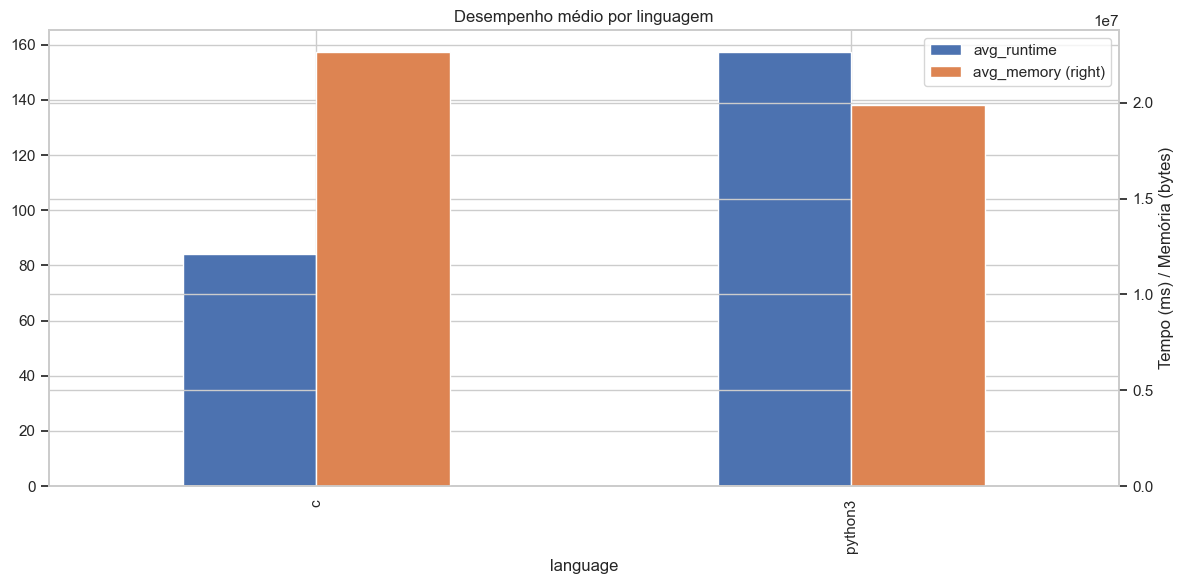

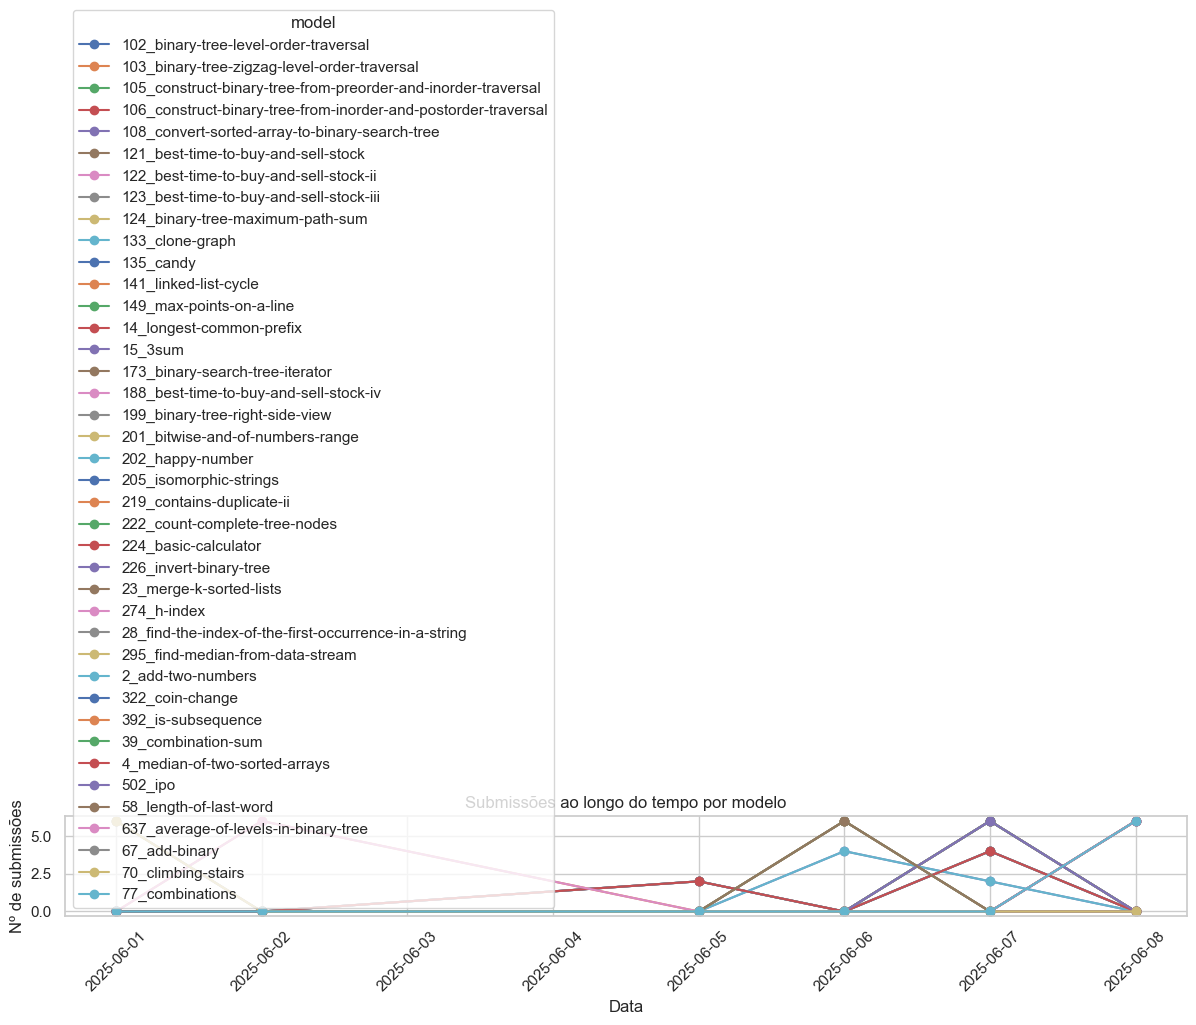

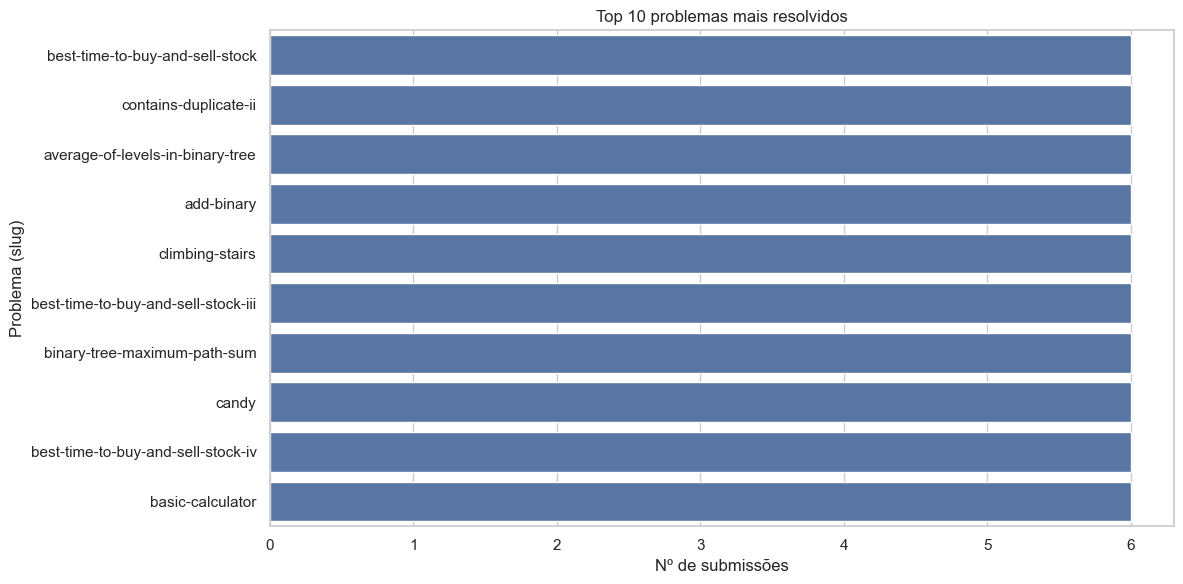

In [10]:

# Configuração padrão para gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Remove submissões incompletas
df_clean = df.dropna(subset=["model", "runtime", "memory", "language", "problem"])

# 1. Desempenho médio por modelo (runtime e memória)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df_clean, x="model", y="runtime", ax=axes[0])
axes[0].set_title("Distribuição de Runtime por Modelo")
axes[0].set_ylabel("Runtime (ms)")
axes[0].set_xlabel("Modelo (LLM)")

sns.boxplot(data=df_clean, x="model", y="memory", ax=axes[1])
axes[1].set_title("Distribuição de Memória por Modelo")
axes[1].set_ylabel("Memória (bytes)")
axes[1].set_xlabel("Modelo (LLM)")

plt.tight_layout()
plt.show()

# 2. Taxa média de acerto por modelo
df_clean["accuracy"] = df_clean["total_correct"] / df_clean["total_tests"]
model_acc = df_clean.groupby("model")["accuracy"].mean().sort_values(ascending=False)

sns.barplot(x=model_acc.index, y=model_acc.values)
plt.title("Taxa média de acerto por modelo")
plt.ylabel("Taxa de acerto")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.show()

# 3. Linguagens mais utilizadas e desempenho médio
lang_stats = df_clean.groupby("language").agg(
    count=("language", "count"),
    avg_runtime=("runtime", "mean"),
    avg_memory=("memory", "mean")
).sort_values(by="count", ascending=False)

lang_stats.head(10).plot(kind="bar", y=["avg_runtime", "avg_memory"], secondary_y="avg_memory")
plt.title("Desempenho médio por linguagem")
plt.ylabel("Tempo (ms) / Memória (bytes)")
plt.xlabel("Linguagem")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Evolução temporal das submissões
df_clean["date"] = df_clean["timestamp"].dt.date
daily_counts = df_clean.groupby(["date", "model"]).size().unstack(fill_value=0)

daily_counts.plot(marker='o')
plt.title("Submissões ao longo do tempo por modelo")
plt.ylabel("Nº de submissões")
plt.xlabel("Data")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Problemas mais resolvidos
top_problems = df_clean["problem"].value_counts().head(10)

sns.barplot(x=top_problems.values, y=top_problems.index)
plt.title("Top 10 problemas mais resolvidos")
plt.xlabel("Nº de submissões")
plt.ylabel("Problema (slug)")
plt.tight_layout()
plt.show()
